In [1]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
import seaborn as sns

logdust_func = open("logdust_3d_func_new.pkl", "rb")
logstdA_func = open("logstdA_func_new.pkl", "rb")
logdust = pickle.load(logdust_func)
logstdA = pickle.load(logstdA_func)

2022-11-02 23:35:03.359218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 23:35:04.043729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 23:35:04.043755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-02 23:35:04.124212: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 23:35:05.347446: W tensorflow/stream_executor/platform/de

In [2]:
# rcParams.update({'xtick.major.pad': '7.0'})
# rcParams.update({'xtick.major.size': '7.5'})
# rcParams.update({'xtick.major.width': '1.5'})
# rcParams.update({'xtick.minor.pad': '7.0'})
# rcParams.update({'xtick.minor.size': '3.5'})
# rcParams.update({'xtick.minor.width': '1.0'})
# rcParams.update({'ytick.major.pad': '7.0'})
# rcParams.update({'ytick.major.size': '7.5'})
# rcParams.update({'ytick.major.width': '1.5'})
# rcParams.update({'ytick.minor.pad': '7.0'})
# rcParams.update({'ytick.minor.size': '3.5'})
# rcParams.update({'ytick.minor.width': '1.0'})
# rcParams.update({'axes.titlepad': '15.0'})
# rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [3]:
samp_size = 5

def get_NN_pred_mean(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_mean2(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_std(model_A, model_std, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred_mean = model_A(X_data_flattened, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_mean = (pred_mean.numpy() - 0.111) * 1/1.22

    # UGLY not best way to do this but np.append didn't work
    inp = []
    for i,x in enumerate(X_data_flattened):
      single_inp = [xa for xa in x] + list(pred_mean[i])
      inp.append(single_inp)
    
    inp = np.asarray(inp)
    print(inp.shape)
    pred_std = model_std(np.asarray(inp), training=False)
    pred_std = tf.reshape(pred_std, pred_std.shape[0])
    # pred_np = pred_np.reshape([len(X_data), SAMPLE_SIZE])
    return pred_std

def cart2spherical(x, y, z):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    if (x > 0):
        phi = np.arctan(y/x)
    elif (x < 0):
        phi = np.arctan(y/x) +np.pi 
    else:
        phi = np.pi / 2
    return [r, theta, phi] 

def spherical2cart(r, theta, phi):
    '''Return cartesian coordinate from polar coordinate'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

In [4]:
# load each model
modelA_mean = tf.keras.models.load_model('models/modelA/modelA_mean')
modelB_mean = tf.keras.models.load_model('models/modelB/modelB_mean')
modelC_mean = tf.keras.models.load_model('models/modelC/modelC_mean')
modelD_mean = tf.keras.models.load_model('models/modelD/modelD_mean')
modelD_std = tf.keras.models.load_model('models/modelD/modelD_std')

In [5]:
data = np.load('datasets/dust_sim_final_new.npz', allow_pickle=True)
Xo_train, Xo_valid, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
Yo_train, Yo_valid, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']
X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

# used to test
test_data = Xo_test[:,0]

In [6]:
# TODO: this is inconsistent - just loop through X_test values not the whole Xgrid
intrinsic = [np.exp(logdust(x,y,z)) for x,y,z in test_data]
intrinsic_std = [np.exp(logstdA(x,y,z)) for x,y,z in test_data]

def get_underlying_dust(model_mean, X):
    # getting rho
    dA_dx, dA_dy, dA_dz = [], [], []
    norm = model_mean.get_layer('norm')
    dense_1 = model_mean.get_layer('dense_1')
    dense_2 = model_mean.get_layer('dense_2')
    dense_3 = model_mean.get_layer('dense_3')
    pred = model_mean.get_layer('predictions')

    for x,y,z in X:
        xyz = tf.constant([x, y, z])
        with tf.GradientTape() as g:
            g.watch(xyz)
            Y = pred(dense_3(dense_2(dense_1(norm(tf.convert_to_tensor([xyz]))))))
        dA_dxyz = g.gradient(Y, xyz)
        dA_dx.append(dA_dxyz[0])
        dA_dy.append(dA_dxyz[1])
        dA_dz.append(dA_dxyz[2])

    r = np.sqrt(np.square(X[:, 0]) + np.square(X[:, 1]) + np.square(X[:, 2]))
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    x_over_r = np.divide(x, r)
    y_over_r = np.divide(y, r)
    z_over_r = np.divide(z, r)
    dA_dr = np.multiply(dA_dx, x_over_r) + np.multiply(dA_dy, y_over_r) + np.multiply(dA_dz, z_over_r)
    return dA_dr

In [9]:
pred_A_modelA = modelA_mean(test_data)
dA_dr_modelA = get_underlying_dust(modelA_mean, test_data)

In [10]:
pred_A_modelB = modelB_mean(test_data)
dA_dr_modelB = get_underlying_dust(modelB_mean, test_data)

In [11]:
pred_A_modelC = modelC_mean(test_data)
dA_dr_modelC = get_underlying_dust(modelC_mean, test_data)

In [12]:
pred_A_modelD = modelD_mean(test_data)
dA_dr_modelD = get_underlying_dust(modelD_mean, test_data)

In [7]:
pred_mean = get_NN_pred_mean(modelD_mean, test_data)
pred_mean = np.reshape(pred_mean, (pred_mean.shape[0], 1))
model_std_inps = np.append(test_data, pred_mean, axis=1)

pred_std_modelD = get_std_model_pred(modelD_std, model_std_inps, np.log(0.13410718414757786), training=False)
pred_std_modelD = np.reshape(pred_std_modelD, np.shape(pred_std_modelD)[0])
pred_std_modelD = np.exp(pred_std_modelD)

In [13]:
# some reshaping 
num_data = X_test[:,0].shape[0]
pred_A_modelA = np.reshape(pred_A_modelA, num_data)
pred_A_modelB = np.reshape(pred_A_modelB, num_data)
pred_A_modelC = np.reshape(pred_A_modelC, num_data)
pred_A_modelD = np.reshape(pred_A_modelD, num_data)
pred_std_modelD = np.reshape(pred_std_modelD, pred_std_modelD.shape[0])
modelC_final_variable_std = 0.12374137631361162
modelC_final_variable_std_repeated = np.array([modelC_final_variable_std] * num_data)
point2_repeated = np.array([0.2] * num_data)

In [20]:
delta_r = 0.001
delta_r_val = delta_r
ngrid, edge = 21, 2.5
max_r = edge * 2
min_points=10 # min points to along LOS to star to calculate A

In [69]:
def pred_along_los(subplot_i, i, samps, true_A, modelA, modeltype, 
                   modelstd=None, constantstd=None, 
                   mean_color='#8f0000', sigma_color='#FFF59E', 
                   y_label=None):
    '''los: r, theta, phi
    i: index of X_test position for the LOS - same index as star on the LOS '''
    # x, y, z = X_test[X_test_i]
    # r, theta, phi = cart2spherical(x,y,z)
    # los_pos, los_pos_r = [], []
    # valid_r = 0
    n_samps, _ = samps.shape
    
    # TODO change this so it's the true A
    x, y, z = X_test[i]
    r, _, _ = cart2spherical(*X_test[i])
    plt.plot(r, Y_test[i], marker="o", markersize=5, markeredgecolor="white", markerfacecolor="#674747") 
    
    # get the rs of samps
    rs_los=[]
    for samp in samps:
        r, _, _ = cart2spherical(*samp)
        rs_los.append(r)
    
    # 5 sample of X and their predictions
    rs, ys = [], []
    for X in Xo_test[i]:
        r, _, _ = cart2spherical(*X)
        rs.append(r)
    ys = modelA(Xo_test[i], training=False) 
    plt.scatter(rs, ys, marker="o", color='blue', linestyle='-', linewidth = 0.5, edgecolor='black', s=10) 
    
    # los_pos = np.asarray(los_pos)
    # X_data_flattened = los_pos.reshape([len(los_pos), 3])
    # pred = modelA(X_data_flattened, training=False).numpy().reshape([len(los_pos)]) # (len(X_data) * SAMPLE_SIZE, 3)
    pred = modelA(samps, training=False)

    if modeltype == 'D':
        # pred_A_reshaped = pred.reshape([n_samps, 1])
        # model_std_inps = np.append(X_data_flattened, pred_A_reshaped, axis=1)
        model_std_inps = np.append(samps, pred, axis=1)
        pred_std = get_std_model_pred(modelstd, model_std_inps, np.log(0.12374137631361162), training=False) # TODO: don't forget to get the correct value
        pred_std = np.reshape(pred_std, np.shape(pred_std)[0])
        pred_std = np.exp(pred_std) * 10
    else:
        pred_std = constantstd
    
    pred = np.reshape(pred, (np.shape(pred)[0]))

    ax = plt.subplot(4, 3, subplot_i)
    # dont draw sigma for baseline model
    if (modeltype != 'A'):
        ax.fill_between(rs_los, np.array(pred) - pred_std, np.array(pred) + pred_std, color=sigma_color, alpha=0.8)
        ax.fill_between(rs_los, true_A - pred_std, true_A + pred_std, color='grey', alpha=0.4)
    
    # predicted and true A
    ax.plot(rs_los, pred, color=mean_color, linestyle='-', linewidth = 0.1, marker = 'o', ms = 1, markeredgewidth=0.2)
    ax.plot(rs_los, true_A, color='grey', linestyle='-', linewidth = 0.1, marker = 'o', ms = 1, markeredgewidth=0.2)
    
        
    # plt.axvline(x = valid_r, color='black') # new: not plotting black line
    # plt.xlim([0, max_r])
    plt.ylim([0, 10])

    if subplot_i <= 3: # for first three plots add los title
        title = str(np.around(x / r, 2)) + 'i + ' + str(np.around(y/r, 2)) + 'j + ' + str(np.around(z/r, 2)) + ' k'
        plt.title(r'${0}$'.format(title), y=1.1)
    
    if y_label != None:
        plt.ylabel(y_label, rotation='horizontal', labelpad=50)

### Get samples along three LOS
- one towards region with high dust density
- one towards region with low dust density
- one towards region with large sigma

In [26]:
# get underlying true dust for LOS 1,2,3
# first calculate the positions of all the samples along LOS which are INSIDE the box and valid
def get_valid_los_samps(i):
    '''
    i: index of X_test position for the LOS
    return a list of X positions along the LOS that are inside the box in euclidean coords!!
    '''
    x, y, z = X_test[i]
    _, theta, phi = cart2spherical(x,y,z)
    los_pos_r = []
    for r_prime in np.arange(0, max_r, delta_r):
        pos_prime = spherical2cart(r_prime, theta, phi) # NEW: just to know if point lies outside of the box
        x_prime, y_prime, z_prime = pos_prime
        if (x_prime > edge or x_prime < -edge or y_prime > edge or y_prime < -edge or z_prime > edge or z_prime < -edge):
            break # if outside the edge of box stop taking samples
        los_pos_r.append(pos_prime)
    return np.array(los_pos_r)

# for now picking these
i1, i2, i3 = 2, 55, 101
samps_los1=get_valid_los_samps(i1)
samps_los2=get_valid_los_samps(i2)
samps_los3=get_valid_los_samps(i3)
print(samps_los1.shape, samps_los2.shape, samps_los3.shape)

(2717, 3) (3383, 3) (2556, 3)


### Calculate A along the LOS samps found

In [43]:
# get A for all points along LOS 
def get_A(x_samps):
    '''
    x_samps: x samples along a LOS in euclidean coords
    returns A for each samp
    '''
    n_samps, _ = x_samps.shape
    A_true = np.zeros(n_samps)  # stores the A values along LOS
    
    # calculate A for each samp
    for i, X in enumerate(x_samps):
        prog=round(i/len(x_samps)*100)
        if (prog % 10 == 0):
            print(str(prog) + ' ', end='')
        
        # ....x
        delta_r = delta_r_val               # set it back to original value

        # each line of sight must have at least n_points along it to calculate the integral to deal with r < delta_r 
        los_samps=x_samps[:i+1] 
        if len(los_samps) < min_points:
            r, theta, phi = cart2spherical(*X)  # samp eucl coord to original
            delta_r = r / min_points
            r_primes = np.linspace(0, r, min_points) 
            # nnew los samps
            los_samps = np.array([spherical2cart(r_prime, theta, phi) for r_prime in r_primes])

        dust = np.array([np.exp(logdust(x, y, z)) for x,y,z in los_samps]) # include the sample
        dust *= np.array([delta_r])
        trueA = np.sum(dust) 
        A_true[i] = trueA
        
    # convert nan values to 0 - only first value of A is for some reason 0
    A_true[np.isnan(A_true)] = 0
    return A_true

A_los1=get_A(samps_los1)
A_los2=get_A(samps_los2)
A_los3=get_A(samps_los3)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/tmp/ipykernel_73748/2342302680.py:41: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(z/r)


10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 100 100 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20

In [54]:
print(samps_los1)

[[ 0.       -0.        0.      ]
 [ 0.000284 -0.00027   0.00092 ]
 [ 0.000568 -0.000539  0.00184 ]
 ...
 [ 0.7701   -0.731936  2.497401]
 [ 0.770384 -0.732206  2.498321]
 [ 0.770667 -0.732475  2.499241]]


So I think for a sketch we actually don't have to do a ton of modifications to your initial version. I think pretty much we want:
- DONE 4 rows (one for each model ABCD)
- DONE WIP 3 columns (for 3 different LOS; one towards region with high dust density, one towards region with low dust density, one towards region with large sigma)
- DONE For each subplot, we'll want to show the true A and sigma values for the LOS profile (so this will be the same for each column)
- For each subplot, we'll want to show the predictions from our model for A and sigma [if available] (same colours as your previous residual plots).

/tmp/ipykernel_73748/2342302680.py:41: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(z/r)
/tmp/ipykernel_73748/1059272111.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 3, subplot_i)


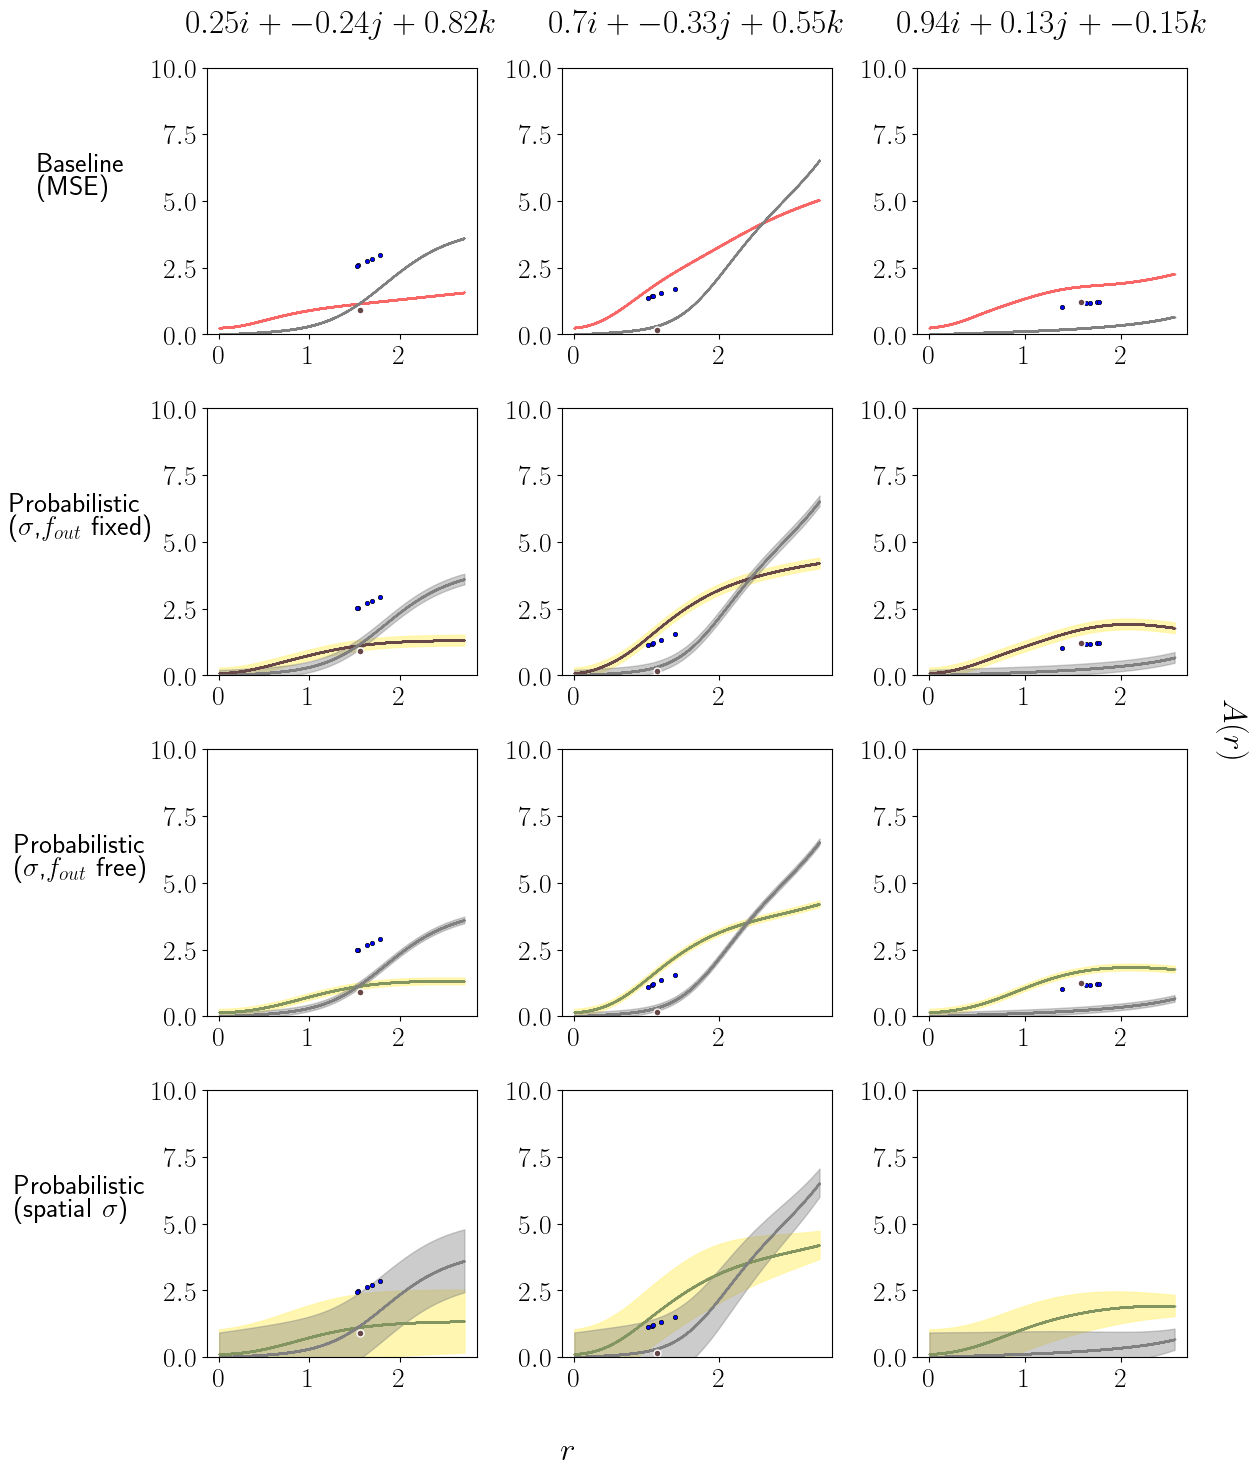

In [70]:
fig = plt.figure(figsize=(13, 15), tight_layout=True)
lims, std_lims = [-1, 10], [0, 0.4]
color1, color2, color3, color4 = "#F96666", "#674747", "#829460", "#182747" # TODO: replace with these colors
fig.supxlabel(r'$r$')
fig.supylabel(r'$A(r)$', ha="right", x=1.025, rotation=270)

# model A
# TODO: for later change this trueA_los1
pred_along_los(1, i1, samps_los1, A_los1, modelA_mean, 'A', mean_color=color1, y_label="Baseline\n(MSE)")
pred_along_los(2, i2, samps_los2, A_los2, modelA_mean, 'A', mean_color=color1)
pred_along_los(3, i3, samps_los3, A_los3, modelA_mean, 'A', mean_color=color1)

# # model B
pred_along_los(4, i1, samps_los1, A_los1, modelB_mean, 'B', constantstd=0.2, mean_color=color2, y_label="Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" fixed)")
pred_along_los(5, i2, samps_los2, A_los2, modelB_mean, 'B', constantstd=0.2, mean_color=color2)
pred_along_los(6, i3, samps_los3, A_los3, modelB_mean, 'B', constantstd=0.2, mean_color=color2)

# # # model C
pred_along_los(7, i1, samps_los1, A_los1, modelC_mean, 'C', constantstd=modelC_final_variable_std, mean_color=color3, y_label="Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" free)")
pred_along_los(8, i2, samps_los2, A_los2, modelC_mean, 'C', constantstd=modelC_final_variable_std, mean_color=color3)
pred_along_los(9, i3, samps_los3, A_los3, modelC_mean, 'C', constantstd=modelC_final_variable_std, mean_color=color3)

# # # model D
pred_along_los(10, i1, samps_los1, A_los1, modelD_mean, 'D', modelstd=modelD_std, mean_color=color3, y_label="Probabilistic\n(spatial "+r'$\sigma$'+")")
pred_along_los(11, i2, samps_los2, A_los2, modelD_mean, 'D', modelstd=modelD_std, mean_color=color3)
pred_along_los(12, i3, samps_los3, A_los3, modelD_mean, 'D', modelstd=modelD_std, mean_color=color3)

plt.savefig('plots/4panel_los_2.png', bbox_inches='tight')